<a href="https://colab.research.google.com/github/DiGyt/snippets/blob/master/predicting_complex_systems_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-addons -q

     |████████████████████████████████| 1.1 MB 5.0 MB/s 


In [ ]:
import datetime

import tensorflow as tf
import tensorflow_addons as tfa
%load_ext tensorboard
import numpy as np

import matplotlib.pyplot as plt

## data generation

In [ ]:
def lorenz_process(n_steps, burn_in=0.1, s=10, r=28, b=8/3,
                   dt=0.001, x_0=0, y_0=1, z_0=1.05, noise_std=0):
  """Create a Process based on the Lorenz equations."""

  # burn in as a fraction of total samples
  if burn_in < 1:
    burn_in = int(n_steps * burn_in)
  
  xs, ys, zs = [x_0], [y_0], [z_0]

  noise = np.cumsum(np.random.randn(n_steps + burn_in, 3), axis=0)
  noise /= np.std(noise, axis=0)  # TODO: remove again

  for i in range(1, n_steps + burn_in):

    # append the lorenz functions
    xs.append(xs[-1] + (s * (ys[-1] - xs[-1])) * dt)
    ys.append(ys[-1] + (r * xs[-1] - ys[-1] - xs[-1] * zs[-1]) * dt)
    zs.append(zs[-1] + (xs[-1] * ys[-1] - b * zs[-1]) * dt)

    if noise_std > 0:
      #noise = np.random.randn(3) * noise_std
      #xs[-1] += noise[0]
      #ys[-1] += noise[1]
      #zs[-1] += noise[2]
      xs[-1] += noise[i, 0]
      ys[-1] += noise[i, 1]
      zs[-1] += noise[i, 2]

  return np.stack([xs, ys, zs], axis=-1)[burn_in:]


data = lorenz_process(100000, 0.1, dt=0.001,noise_std=.1)
data.shape

(100000, 3)

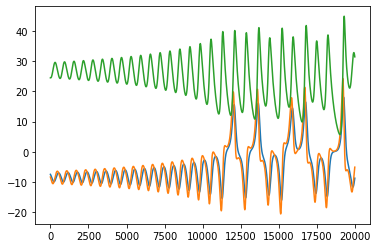

In [ ]:
plt.plot(lorenz_process(20000, 0.1, dt=0.001, noise_std=0));

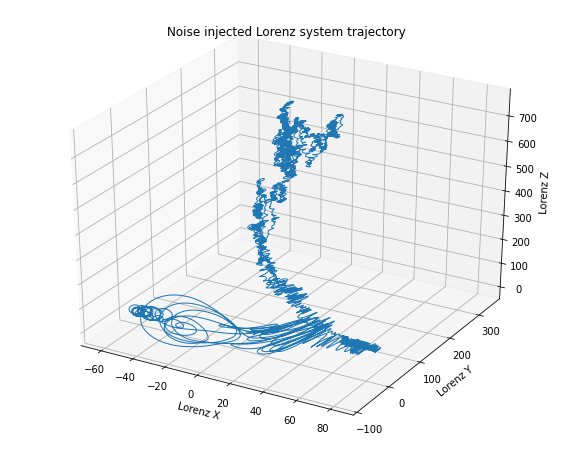

In [ ]:
# Plot true
fig = plt.figure(figsize=[10,8])
ax = fig.gca(projection='3d')

ax.plot(data[:, 0], data[:, 1], data[:, 2], lw=1)
ax.set_xlabel("Lorenz X")
ax.set_ylabel("Lorenz Y")
ax.set_zlabel("Lorenz Z")
ax.set_title("Noise injected Lorenz system trajectory")

plt.show()

In [ ]:
def add_noise(data, r2 = 1., noise="gaussian", axis=0):

  if isinstance(noise, str):
    if noise == "gaussian":
      noise = np.random.randn(*data.shape)
    elif noise == "uniform":
      noise = np.random.rand(*data.shape)
    elif noise == "randwalk":
      noise = np.cumsum(np.random.randn(*data.shape), axis=axis)
  #noise = b
  # normalize the noise std
  noise /= np.std(noise, axis=axis)

  #err_std = np.sqrt(-(np.std(y)**2)*(r2-1))/np.sqrt(r2)
  # another form, assuming r2 and std(y) are positive, which they are
  err_std = np.sqrt(1 / r2 - 1) * np.std(data, axis=axis, keepdims=True)

  return data + noise * err_std


In [ ]:
def add_noise_p(data, r2 = 1., noise="gaussian", axis=0):
  """Aiming to work for correlated noise.
  the equation works. However it makes no sense to just scale it.
  Obviously scaling a correlated variable wont change the correlation. We need the possibility
  to rotate it from signal to uncorrelated noise in order to change it.
  One idea would be to make the function work like:
  correct_corr_noise = f(data, incorrectly_corr_noise, uncorrelated_noise, r2)
  and then rework the functions for cov(a, b + x) again. This looks ugly but might
  be cool as it is a generalized form...

  This does also mean that the function here is not better than the other one (in terms of precision)

  maybe you can go recursive in order to make the spurious correlation smaller than some value
  perfectly_uncorrelated_rwalk = f(data, f(data, rwalk, "gaussian"), "gaussian")

  like: if np.corrcoef(data, noise) > 0.03: noise = f(data, noise, "noise_type")
  """

  if isinstance(noise, str):
    if noise == "gaussian":
      noise = np.random.randn(*data.shape)
    elif noise == "uniform":
      noise = np.random.rand(*data.shape)
    elif noise == "randwalk":
      noise = np.cumsum(np.random.randn(*data.shape), axis=axis)
  #noise = data + np.random.randn(*data.shape) * 0.01  # TODO: remove again  
  # normalize the noise std
  noise /= np.std(noise, axis=axis)

  var_a = np.var(data, axis=axis)
  cov_ax = axis_cov(data, noise, axis=axis)
  err_std = np.sqrt((var_a**2 * -r2 + var_a**2 - 2 * var_a * cov_ax * r2 + 2 * var_a * cov_ax + cov_ax ** 2) / (var_a * r2))
  # this assumes that var_a, cov_ax, and r2 are positive (< 0)!. Not sure if we can take that, especially for r2.
  #err_std = np.sqrt(cov_ax**2/(var_a * r2) + var_a * ((1 / r2) - 1) + 2 * cov_ax * ((1/r2) - 1))
  return data + noise * err_std


In [ ]:
def axis_cov(A, B, axis=0):
  A = np.moveaxis(A, source=axis, destination=-1)
  B = np.moveaxis(B, source=axis, destination=-1)

  import itertools
  loopover = [range(s) for s in A.shape[:-1]]
  indices = itertools.product(*loopover)
  
  covs = np.zeros(A.shape[:-1])
  for idx in indices:
    #idx = np.array(idx)
    covs[idx] = np.cov(A[idx], B[idx])[0, 1]
  return covs

def axis_corrcoef(A, B, axis=0):
  A = np.moveaxis(A, source=axis, destination=-1)
  B = np.moveaxis(B, source=axis, destination=-1)

  import itertools
  loopover = [range(s) for s in A.shape[:-1]]
  indices = itertools.product(*loopover)
  
  corrs = np.zeros(A.shape[:-1])
  for idx in indices:
    #idx = np.array(idx)
    corrs[idx] = np.corrcoef(A[idx], B[idx])[0, 1]
  return corrs


In [ ]:
r2 = 0.22
a = np.stack([data for _ in range(4)], axis=-1)
b = add_noise(a, r2 = r2, noise="randwalk", axis=0)
c = add_noise_p(a, r2 = r2, noise="randwalk", axis=0)

axis_corrcoef(a, b)**2, axis_corrcoef(a, c)**2

(array([[0.99999931, 0.99999931, 0.99999931, 0.99999931],
        [0.99999947, 0.99999947, 0.99999947, 0.99999946],
        [0.99999942, 0.99999942, 0.99999942, 0.99999942]]),
 array([[0.99999925, 0.99999926, 0.99999925, 0.99999926],
        [0.99999943, 0.99999942, 0.99999942, 0.99999942],
        [0.99999938, 0.99999938, 0.99999938, 0.99999938]]))

(array([ 3039.,  5876.,  4900.,  2926.,  2480.,  7821., 20865., 23817.,
        17450., 10826.]),
 array([-85.40014048, -43.62158644,  -1.84303241,  39.93552163,
         81.71407567, 123.49262971, 165.27118375, 207.04973778,
        248.82829182, 290.60684586, 332.3853999 ]),
 <a list of 10 Patch objects>)

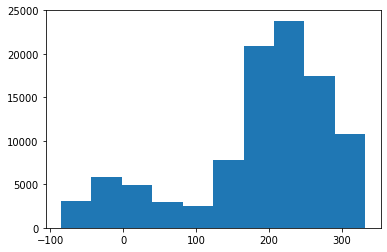

In [ ]:
plt.hist(np.cumsum(np.random.randn(len(data))))

In [ ]:
np.corrcoef(data[:, 0],
            add_noise(data, r2 = .4, noise="randwalk", axis=0)[:, 0]) ** 2

array([[1.        , 0.37101154],
       [0.37101154, 1.        ]])

(100000, 3)
(1, 3)


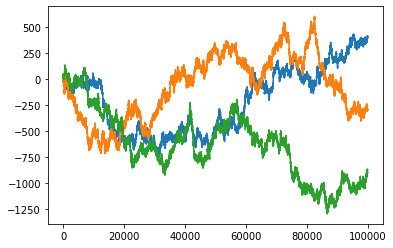

In [ ]:
plt.plot(add_noise(data, r2 = .9, noise="randwalk", axis=0));

In [ ]:
for i in range(data.shape[1]):
  plt.plot(add_convoluted_noise(data.copy(), r2=0.8, periods=4237)[:4000, i])

NameError: ignored

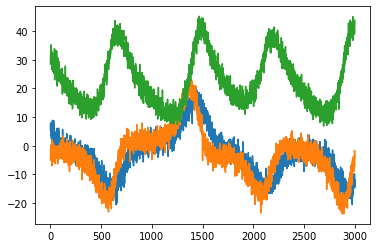

In [ ]:
# add the noise
#data = add_convoluted_noise(data, r2=0.8, periods=999)
data = add_noise(data, r2=0.98)

for i in range(data.shape[1]):
  plt.plot(data[:3000, i])

## data preprocessiong

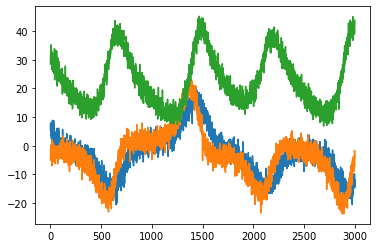

In [ ]:
# clean it again. this is now part of the preprocessiong
#data = moving_average(data, 100)
# TODO: Use kalman filters instead of MA
# This should be exactly what they are there for.
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.kalman_filter.KalmanFilter.html

for i in range(data.shape[1]):
  plt.plot(data[:3000, i])

In [ ]:
x = data[:-1]
y = data[1:]

n_samples = 60
x =  np.stack([x[i:i+n_samples, :] for i in range(len(x) - n_samples)])
y = y[n_samples:, :]

split = 70000
x_train = x[:split, :]
y_train = y[:split, :]
x_test = x[split:, :]
y_test = y[split:, :]

# normalize
avg, std = np.mean(x_train), np.std(x_train)
x_train = (x_train - avg) / std
y_train = (y_train - avg) / std
x_test = (x_test - avg) / std
y_test = (y_test - avg) / std

In [ ]:
# Convert to tensorflow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Process validation data in full batch
validation_dataset = validation_dataset.batch(x_test.shape[0])


In [ ]:
# First, let's define a RNN Cell, as a layer subclass.

class Reservoir(tf.keras.layers.Layer):

  def __init__(self, units, t_unfold, trainable=True, **kwargs):
    self.units = units
    self.t_unfold = t_unfold
    self.trainable =trainable
    self.batch_norm = tf.keras.layers.BatchNormalization()
    super(Reservoir, self).__init__(**kwargs)

  def build(self, input_shape):
    self.w_input = self.add_weight(shape=(input_shape[-1], self.units),
                                  initializer='normal',
                                  name='w_input', trainable=self.trainable)
    self.w_reservoir = self.add_weight(shape=(self.units, self.units),
                                  initializer='normal',
                                  name='w_reservoir', trainable=self.trainable)
    
    self.b_input = self.add_weight(shape=(self.units,),
                                  initializer='normal',
                                  name='w_input', trainable=self.trainable)
    self.b_reservoir = self.add_weight(shape=(self.units,),
                                  initializer='normal',
                                  name='w_reservoir', trainable=self.trainable)
    self.built = True

  def call(self, inputs, training=False):

    state = tf.matmul(inputs, self.w_input) + self.b_input
    state = tf.keras.activations.tanh(state)
    states = tf.zeros(state.shape + [1])
    for i in range(self.t_unfold):
      state = tf.matmul(state, self.w_reservoir + self.b_reservoir)
      state = tf.keras.activations.tanh(self.batch_norm(state, training=training))
      states = tf.concat([states, tf.expand_dims(state, axis=2)],axis=2)
    #states = tf.stack([tf.keras.activations.tanh(self.batch_norm(tf.matmul(state, self.w_reservoir + self.b_reservoir), training=training)) for i in range(self.t_unfold)], axis=2)


    
    return states

# Define the model Using
#"""
model = tf.keras.Sequential()
model.add(Reservoir(1024, 15, trainable=True))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Dense(3))
#"""
model = tf.keras.Sequential()
lstms = [tf.keras.layers.LSTMCell(64//i, recurrent_activation="sigmoid") for i in range(1, 3)]
model.add(tf.keras.layers.RNN(tf.keras.layers.StackedRNNCells(lstms), return_sequences=False))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Dense(3))
#"""
# build it
model.build(input_shape=x.shape)
model.summary()

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn_49 (RNN)                 (99940, 32)               29824     
_________________________________________________________________
flatten_50 (Flatten)         (99940, 32)               0         
_________________________________________________________________
dense_100 (Dense)            (99940, 32)               1056      
_________________________________________________________________
dense_101 (Dense)            (99940, 3)                99        
Total params: 30,979
Trainable params: 30,979
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Set up TensorBoard
!rm -rf ./logs/ 
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
%tensorboard --logdir logs/gradient_tape/

# clear the session
#tf.keras.backend.clear_session()
"""
model = tf.keras.Sequential()
model.add(Reservoir(1024, 15, trainable=False))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Dense(3))
#"""
model = tf.keras.Sequential()
lstms = [tf.keras.layers.LSTMCell(128//i) for i in range(1, 4)]
model.add(tf.keras.layers.RNN(tf.keras.layers.StackedRNNCells(lstms), return_sequences=False))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Dense(3))
#"""
# define important parameters
num_epochs = 200
batch_size = 128
learning_rate = 0.005


cur_lr = learning_rate # 1e-5
def get_lr():
  global cur_lr
  return cur_lr

loss_func = tf.keras.losses.MSE
optimizer = tf.keras.optimizers.Adam(learning_rate=get_lr)

step = 0
best_loss = 1e7
for epoch in range(num_epochs):

  # Newly shuffle and batch the train data each epoch
  batched_dataset = train_dataset.shuffle(buffer_size = x_train.shape[0]).batch(batch_size)

  for x, y in batched_dataset:


    with tf.GradientTape() as tape:
      outputs = model(x, training=True)
      #outputs = tf.reduce_mean(outputs, axis=1)
      loss = loss_func(y, outputs)

      gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    with train_summary_writer.as_default():
      tf.summary.scalar('train loss', tf.reduce_mean(loss), step=step)

    #if step % 7 == 0: # alterantive shock: cur_lr*200 every 777 steps
    #  shock = [tf.random.normal(shape=grad.shape, stddev=cur_lr*2) for grad in gradients]
    #  optimizer.apply_gradients(zip(shock, model.trainable_variables))


    # increment step
    step += 1


    # test
    if step % 10 == 0:
      for x, y in validation_dataset:
        outputs = model(x)
        #outputs = tf.reduce_mean(outputs, axis=1)
        loss = loss_func(y, outputs)

      with train_summary_writer.as_default():
        tf.summary.scalar('test loss', tf.reduce_mean(loss), step=step)
        #for ind, (layer, gradient) in enumerate(zip(model.layers, gradients)):
        #  tf.summary.histogram(str(ind) + ": Gradients - " + layer.name, gradient, step=step

    if step % 30 == 0:
      avg_loss = tf.reduce_mean(loss)
      if best_loss < avg_loss:
        cur_lr = cur_lr * np.asscalar(pow(np.random.rand(1),2)) # originally **3
        print('New Learning Rate: ', cur_lr)
      else:
        best_model = model
        best_loss = avg_loss

NameError: ignored

predict the reservoir network

In [ ]:
start_pred = 8000
n_preds = 1000

pred_inp = x_test[start_pred:start_pred+1, :]
preds = pred_inp
for i in range(n_preds):
  cur_pred = best_model(pred_inp).numpy()
  preds = np.concatenate([preds, cur_pred])
  pred_inp = cur_pred

In [ ]:
#preds = best_model(x_test[:4000,:, :]).numpy()
var = 2
plt.plot(preds[:n_preds, var])
plt.plot(y_test[start_pred:start_pred+n_preds, var])
plt.legend(["Prediciton", "True"])

Predict the RNN

In [ ]:
start_pred = 8000
n_preds = 6000

preds = x_test[start_pred:start_pred+1, :, :]
for i in range(n_preds):
  cur_pred = best_model(preds[:, -n_samples:, :]).numpy()[np.newaxis, :, :]
  preds = np.concatenate([preds[:, :, :], cur_pred], axis=1)

In [ ]:
#preds = best_model(x_test[:4000,:, :]).numpy()
var =2
plt.plot(preds[0,:n_preds, var])
plt.plot(y_test[start_pred:start_pred+n_preds, var])
plt.legend(["Prediciton", "True"])

##What do we learn from this?

When confronted with noisy data, and wanting to make global/long term predictions, really consider denoising!

Even if the noise is not pure white noise, but (half) systematic, you can really closely imitate a dynamic system using the combination of moving_average + RNN.

if we look at the RNN performance, it zeros out after ~ 500, if we don't do a moving average beforehand. If we don't it works nicely, going on undefinitely.

### plot the trajectories of the RNN model vs. the original lorenz system

In [ ]:

true_y = y_test[start_pred:start_pred+n_preds, :]
pred_y = preds[0,:n_preds, :]

# Plot true
fig = plt.figure(figsize=[10,8])
ax = fig.gca(projection='3d')

ax.plot(true_y[:, 0], true_y[:, 1], true_y[:, 2], lw=1)
ax.set_xlabel("Lorenz X")
ax.set_ylabel("Lorenz Y")
ax.set_zlabel("Lorenz Z")
ax.set_title("True Lorenz system trajectory")

plt.show()


# Plot pred
fig = plt.figure(figsize=[10,8])
ax = fig.gca(projection='3d')

ax.plot(pred_y[:, 0], pred_y[:, 1], pred_y[:, 2], lw=1)
ax.set_xlabel("Lorenz X")
ax.set_ylabel("Lorenz Y")
ax.set_zlabel("Lorenz Z")
ax.set_title("RNN Model of Lorenz system trajectory")

plt.show()
